In [ ]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
matplotlib.rc('font', size=16)

### Optimization Manifold

$$
  z = (x - 0.1)^2 + (y - 0.1)^2 + 0.5 \\
  \frac{\partial z}{\partial x} = 2(x - 0.1) \\
  \frac{\partial z}{\partial x} = 2(y - 0.1)
$$

In [ ]:
def manifold_z(x, y):
  z_x = (x - 0.1)**2
  z_x = np.expand_dims(z_x, axis = -1)
  z_y = (y - 0.1)**2
  z_y = np.expand_dims(z_y, axis = 0)

  z = (z_x + z_y).transpose()
  return z

def function_z(x, y):
  return (x - 0.1)**2 + (y - 0.1)**2

def dz(x, y): 
  dz_dx = 2*(x - 0.1)
  dz_dy = 2*(y - 0.1)
  return dz_dx, dz_dy

def noisy_dz(x, y):
  dx, dy = dz(x, y)
  r = random.random()
  if random.choice([0, 1]):
    dx, dy = dx*(1 - r), dy*(1 + r)
  else:
    dx, dy = dx*(1 - r), dy*(1 + r)
  return dx, dy

def gradient_path(x_start, y_start, eps=1e-2, steps = 10000):
  x_path = [x_start]
  y_path = [y_start]
  for i in range(steps):
    _x = x_path[-1]
    _y = y_path[-1]
    dx, dy = dz(_x, _y)
    #print(dx, dy)
    nx, ny = _x-eps*dx, _y-eps*dy
    x_path.append(nx)
    y_path.append(ny)

  return np.array(x_path), np.array(y_path)


def noisy_gradient_path(x_start, y_start, eps=1e-2, steps = 10000):
    x_path = [x_start]
    y_path = [y_start]
    for i in range(steps):
      _x = x_path[-1]
      _y = y_path[-1]
      dx, dy = noisy_dz(_x, _y)
      nx, ny = _x-eps*dx, _y-eps*dy
      x_path.append(nx)
      y_path.append(ny)

    return np.array(x_path), np.array(y_path)

In [ ]:
x = np.arange(-1, 1, 0.01)
y = np.arange(-1, 1, 0.01)

z = manifold_z(x, y)

# start gradient path at x = -1, y = 1
x_gpath, y_gpath = gradient_path(-1,  1)
z_gpath = function_z(x_gpath, y_gpath)

x_badg, y_badg = noisy_gradient_path(-1,  1)
z_badg = function_z(x_badg, y_badg)

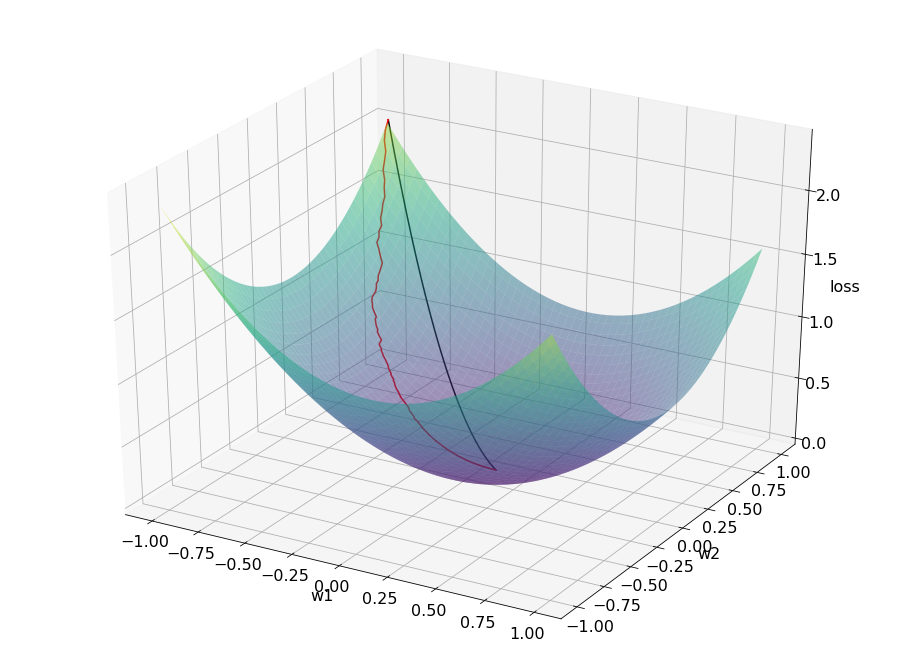

In [ ]:
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111,projection='3d')
ax1.plot_surface(X, Y, z, cmap='viridis', alpha = 0.5)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")
ax1.set_zlabel("loss")

ax1.plot(x_gpath, y_gpath, z_gpath, color = "black")
ax1.plot(x_badg, y_badg, z_badg, color = "red")
plt.show()

## Adam Optimizer

$$
g_t = \nabla_{\theta_t} \mathcal{L}(\theta_t)
$$

$$
m_t = \beta_1m_{t-1} + (1-\beta_1)g_t \\
v_t = \beta_2v_{t-1} + (1-\beta_2)g_t^2 \\
\hat m_t = m_t/(1-\beta_1^t) \\
\hat v_t = v_t/(1-\beta_2^t) \\
g_t = \hat m_t / (\sqrt{\hat v} + \epsilon) 
$$

In [ ]:
# Adam Optimizer

class AdamOptimizer:
  def __init__(self, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.prev_mt = np.array([0, 0])
    self.prev_vt = np.array([0, 0])

  def mt_update(self, prev_mt, gt):
    return self.beta1*prev_mt + (1-self.beta1)*gt

  def vt_update(self, prev_vt, gt):
    gt2 = gt*gt
    return self.beta2*prev_vt + (1-self.beta2)*gt2

  def mt_hat_update(self, mt, time):
    return mt/(1-self.beta1**time)

  def vt_hat_update(self, vt, time):
    return vt/(1-self.beta2**time)

  def adam_update(self, gt, prev_mt, prev_vt, time):
    mt = self.mt_update(prev_mt, gt)
    vt = self.vt_update(prev_vt, gt)
    mt_hat = self.mt_hat_update(mt, time)
    vt_hat = self.vt_hat_update(vt, time)
    #print(mt_hat, vt_hat)
    del_t = mt_hat/(np.sqrt(vt_hat) + self.epsilon)
    return mt, vt, del_t

  def get_adam_dz(self, gt, time):
    mt, vt, del_t = self.adam_update(gt, self.prev_mt, self.prev_vt, time)
    self.prev_mt = mt
    self.prev_vt = vt
    return del_t


In [ ]:
def adam_gradient_path(x_start, y_start, eps=1e-2, steps = 10000):
  adam_optimizer = AdamOptimizer()
  x_path = [x_start]
  y_path = [y_start]
  for i in range(steps):
    _x = x_path[-1]
    _y = y_path[-1]
    dx, dy = dz(_x, _y)
    gt = adam_optimizer.get_adam_dz(np.array([dx, dy]), i+1)
    dx, dy = gt[0], gt[1]
    nx, ny = _x-eps*dx, _y-eps*dy
    x_path.append(nx)
    y_path.append(ny)

  return np.array(x_path), np.array(y_path)



In [ ]:
x_adam, y_adam = adam_gradient_path(-1,  1)
z_adam = function_z(x_adam, y_adam)

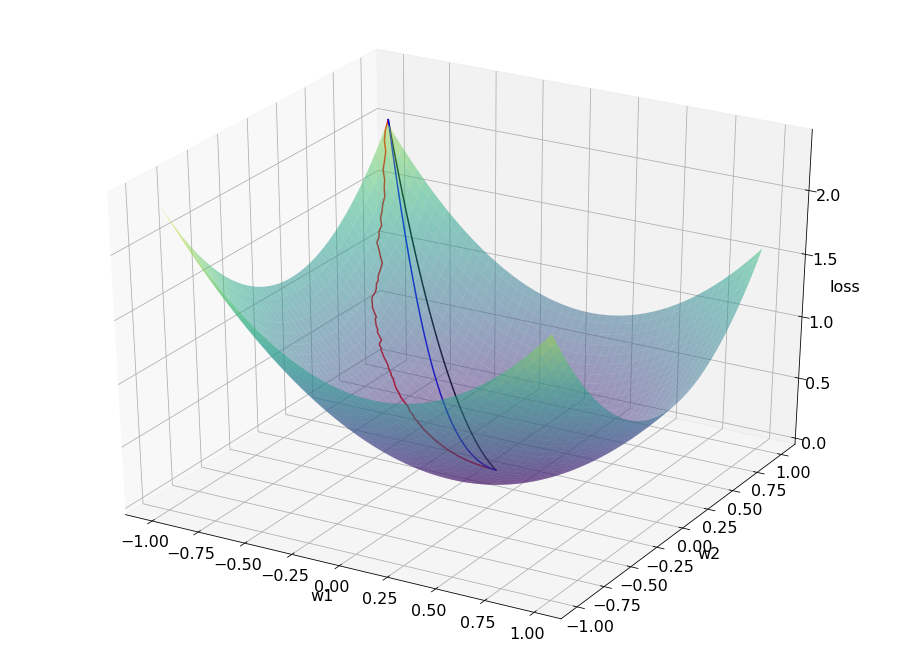

In [ ]:
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111,projection='3d')
ax1.plot_surface(X, Y, z, cmap='viridis', alpha = 0.5)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")
ax1.set_zlabel("loss")

ax1.plot(x_gpath, y_gpath, z_gpath, color = "black")
ax1.plot(x_badg, y_badg, z_badg, color = "red")
ax1.plot(x_adam, y_adam, z_adam, color = "blue")

plt.show()

## Adam on noisy gradients

In [ ]:
def noisy_adam_gradient_path(x_start, y_start, eps=1e-2, steps = 10000):
  adam_optimizer = AdamOptimizer()
  x_path = [x_start]
  y_path = [y_start]
  for i in range(steps):
    _x = x_path[-1]
    _y = y_path[-1]
    dx, dy = noisy_dz(_x, _y)
    gt = adam_optimizer.get_adam_dz(np.array([dx, dy]), i+1)
    dx, dy = gt[0], gt[1]
    nx, ny = _x-eps*dx, _y-eps*dy
    x_path.append(nx)
    y_path.append(ny)

  return np.array(x_path), np.array(y_path)

In [ ]:
x_nadam, y_nadam = noisy_adam_gradient_path(-1,  1)
z_nadam = function_z(x_nadam, y_nadam)

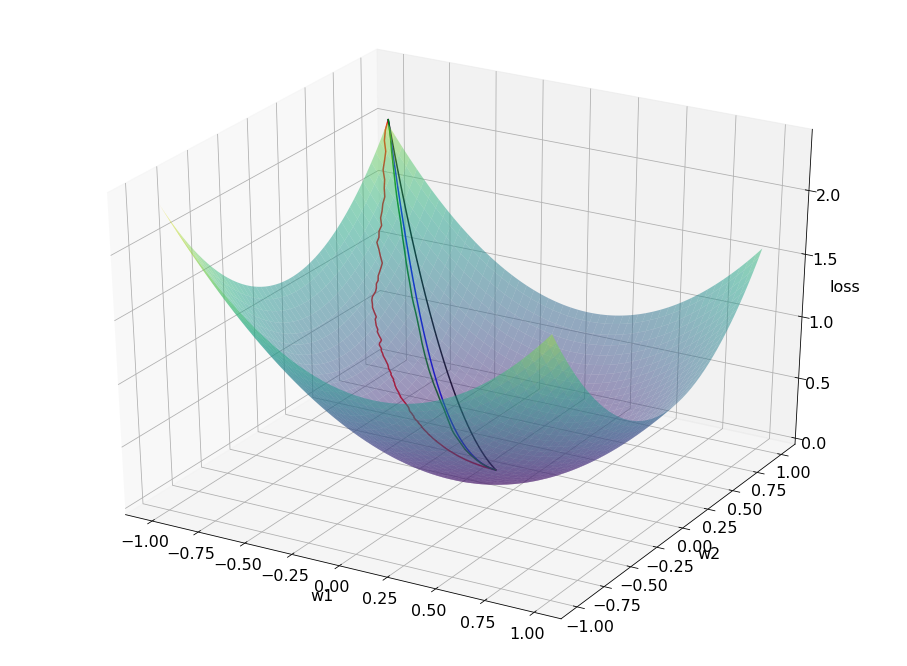

In [ ]:
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111,projection='3d')
ax1.plot_surface(X, Y, z, cmap='viridis', alpha = 0.5)
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")
ax1.set_zlabel("loss")

ax1.plot(x_gpath, y_gpath, z_gpath, color = "black")
ax1.plot(x_badg, y_badg, z_badg, color = "red")
ax1.plot(x_adam, y_adam, z_adam, color = "blue")
ax1.plot(x_nadam, y_nadam, z_nadam, color = "green")

plt.show()

**TODO: \\
Visualize and Compare:**
1. RProp
2. RMSProp
3. AdaGrad
4. AdaDelta